In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Load dataset
digits = load_digits()
X_full = digits["data"]          # (1797, 64)
y_full = digits["target"]        # (1797,)

# Train / test split
X, X_test, y, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full,
)

print("Train X shape:", X.shape)
print("Test  X shape:", X_test.shape)
print("Train y shape:", y.shape)
print("Test  y shape:", y_test.shape)

Train X shape: (1437, 64)
Test  X shape: (360, 64)
Train y shape: (1437,)
Test  y shape: (360,)


Some training digits:


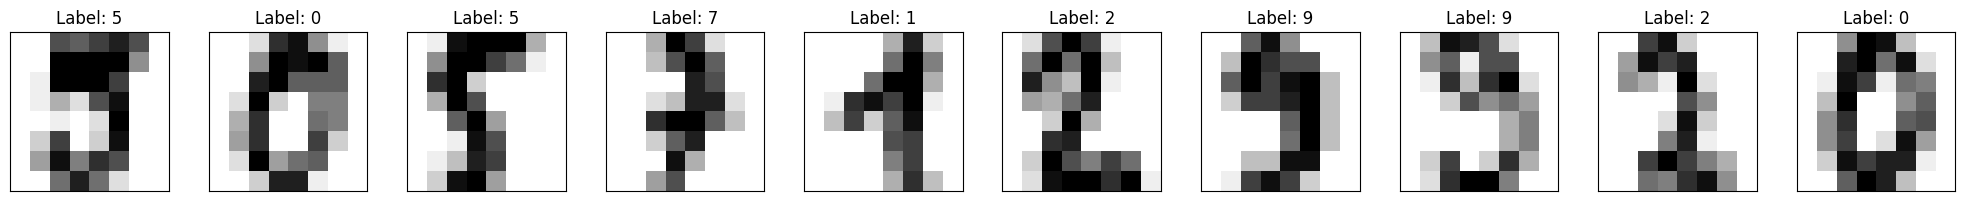

In [103]:
def visualize_digits(images, labels, num_digits=10):
    """
    Visualize a specified number of digits from flattened 8x8 images.
    images: (n_samples, 64)
    labels: (n_samples,)
    """
    fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2, 2))
    for i in range(num_digits):
        img = images[i].reshape(8, 8)
        axes[i].imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.tight_layout()
    plt.show()

print("Some training digits:")
visualize_digits(X, y, num_digits=10)


X_centered shape: (1437, 64)
Covariance matrix shape: (64, 64)


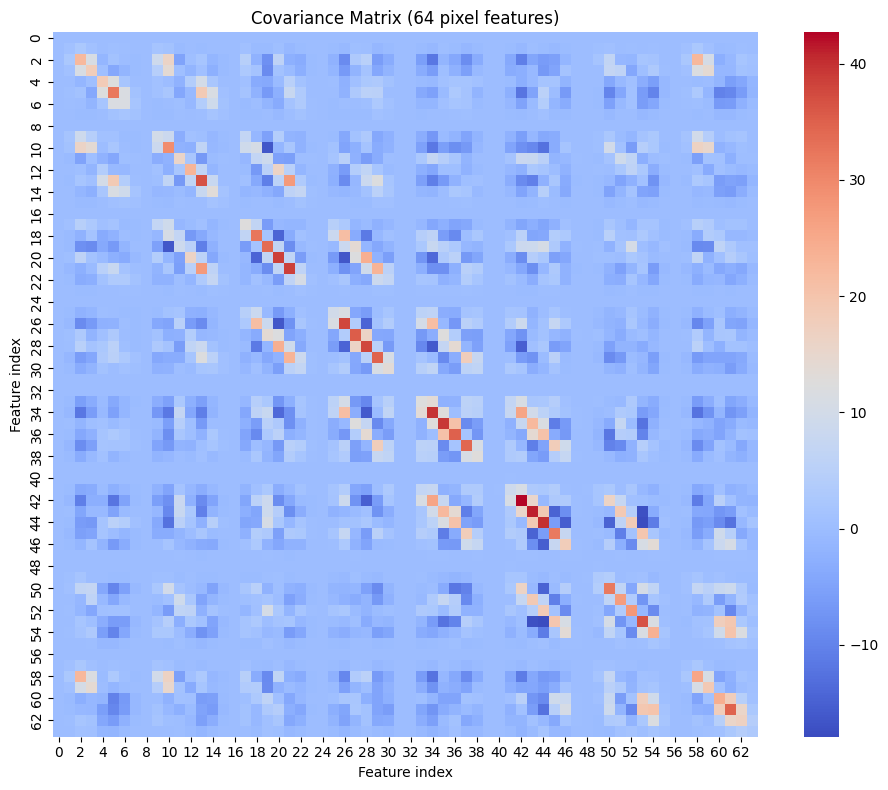

In [117]:
def compute_centered_covariance(X):
    """
    Center columns (features) of X and compute covariance matrix.

    X: (n_samples, n_features)
    Returns:
      X_centered: (n_samples, n_features)
      cov_matrix: (n_features, n_features)
      mu: (1, n_features) mean vector
    """
    mu = X.mean(axis=0, keepdims=True)      # mean of each feature
    X_centered = X - mu                     # center columns
    cov_matrix = np.cov(X_centered, rowvar=False)
    return X_centered, cov_matrix, mu

X_centered, cov_matrix, mu = compute_centered_covariance(X)
X_centered_test = X_test - mu              # center test using train mean

print("X_centered shape:", X_centered.shape)
print("Covariance matrix shape:", cov_matrix.shape)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cov_matrix,
    cmap="coolwarm",
    cbar=True,
    square=True
)
plt.title("Covariance Matrix (64 pixel features)")
plt.xlabel("Feature index")
plt.ylabel("Feature index")
plt.tight_layout()
plt.show()


In [ ]:
# Custom code to compute eigenvalues and eigenvectors
def power_iteration(A, num_iters=1000, tol=1e-8):
    """
    Approximate the dominant eigenvalue/eigenvector of a symmetric matrix A.
    """
    n = A.shape[0]
    v = np.random.randn(n)
    v /= np.linalg.norm(v)

    last_lambda = 0.0
    for _ in range(num_iters):
        w = A @ v
        v = w / np.linalg.norm(w)
        lam = v @ (A @ v)          # Rayleigh quotient

        if abs(lam - last_lambda) < tol:
            break
        last_lambda = lam

    return lam, v


def eigen_decomposition_power(A, k=None, num_iters=1000, tol=1e-8):
    """
    Compute up to k eigenvalues/eigenvectors of symmetric A using
    power iteration + deflation.
    """
    A_work = A.copy().astype(float)
    n = A_work.shape[0]
    if k is None:
        k = n

    eigvals = []
    eigvecs = []

    for _ in range(k):
        lam, v = power_iteration(A_work, num_iters=num_iters, tol=tol)
        eigvals.append(lam)
        eigvecs.append(v)

        # Deflation: remove this eigen-direction from A_work
        A_work = A_work - lam * np.outer(v, v)

    eigvals = np.array(eigvals)
    eigvecs = np.array(eigvecs).T  # columns = eigenvectors

    return eigvals, eigvecs


eigvals_pwr, eigvecs_pwr = eigen_decomposition_power(cov_matrix, k=cov_matrix.shape[0])

print("Eigenvalues shape:", eigvals_pwr.shape)
print("Eigenvectors shape:", eigvecs_pwr.shape)


Eigenvalues shape: (64,)
Eigenvectors shape: (64, 64)


In [110]:
def project_and_reconstruct(X, eigvecs, mu, k):
    """
    Project X onto top-k eigenvectors and reconstruct.

    X: (n_samples, n_features)
    eigvecs: (n_features, n_features) columns = eigenvectors
    mu: (1, n_features)
    """
    W_k = eigvecs[:, :k]                  # (64, k)
    X_centered_local = X - mu             # center with training mean
    Z = X_centered_local @ W_k            # (n_samples, k)
    X_recon = Z @ W_k.T + mu              # back to original space
    return X_recon, Z


idx_pwr = np.argsort(eigvals_pwr)[::-1]
eigvals_pwr_sorted = eigvals_pwr[idx_pwr]

# Reorder eigenvectors from power method accordingly
eigvecs_sorted = eigvecs_pwr[:, idx_pwr]
X_recon_10, Z_10 = project_and_reconstruct(X, eigvecs_sorted, mu, k=10)
print("Reconstructed X (k=10) shape:", X_recon_10.shape)
print("Latent Z (k=10) shape:", Z_10.shape)


Reconstructed X (k=10) shape: (1437, 64)
Latent Z (k=10) shape: (1437, 10)


In [116]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

results = []
for k in [1, 10, 20, 30, 40, 45, 48, 50, 55, 60, 64]:
    # Project train and test onto top-k PCs
    X_recon_train, Z_train = project_and_reconstruct(X, eigvecs_sorted, mu, k=k)
    X_recon_test, Z_test   = project_and_reconstruct(X_test, eigvecs_sorted, mu, k=k)

    clf = GaussianNB()
    clf.fit(Z_train, y)
    y_pred = clf.predict(Z_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((k, acc))

    print(f"k={k:2d}: accuracy = {acc:.4f}")

# print("\nAll results:", results)


k= 1: accuracy = 0.3917
k=10: accuracy = 0.9111
k=20: accuracy = 0.9472
k=30: accuracy = 0.9556
k=40: accuracy = 0.9583
k=45: accuracy = 0.9583
k=48: accuracy = 0.9583
k=50: accuracy = 0.9444
k=55: accuracy = 0.9222
k=60: accuracy = 0.9083
k=64: accuracy = 0.9028
